In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

%matplotlib inline

In [66]:
size, alpha, a, b, h, cp, hp, d, cm, hm = np.loadtxt("Silicate_Table.txt", unpack=True)

In [68]:
print(size)

[    3.5     5.     10.     50.    100.    500.   1000. ]


In [117]:
f1d_alpha = interp1d(size, alpha, fill_value="extrapolate", kind="linear")
f1d_a     = interp1d(size, a, fill_value="extrapolate", kind="linear")
f1d_b     = interp1d(size, b, fill_value="extrapolate", kind="linear")
f1d_h     = interp1d(size, h, fill_value="extrapolate", kind="linear")

In [118]:
Test_sizes = [7.5, 25, 75, 250, 750, 2500]

In [119]:
alpha_test = f1d_alpha(Test_sizes)
a_test     = f1d_a(Test_sizes)
b_test     = f1d_b(Test_sizes)
h_test     = f1d_h(Test_sizes)

## Parametric centroid equation:
$$ \langle Z \rangle = a (\frac{G\sqrt{T}}{n_{e}})^{\alpha} (1 - exp (\frac{GT^{0.5} n_{e}^{-1}}{ h}) ) + b $$

In [72]:
# New function like a press schechter like, combining a power law and an exponential growth.

# New function including powers between -3, 3
# def function(x,alpha1, beta1, gamma1, alpha2, beta2, gamma2):
def function(x, alpha, aa, bb, hh):

    Zcent = aa[:] * (x)**alpha[:] * (1.0 - np.exp(-x/hh[:])) + bb[:]
    
    return Zcent

In [120]:
G = 1.52
T = 7000.
ne = 0.9*0.012
GTn = G*np.sqrt(T) / ne

In [121]:
Zcent_WNM =  function(GTn, alpha_test, a_test, b_test, h_test)

In [122]:
G = 0.6
T = 70.
ne = 36.*1.8e-4
GTn = G*np.sqrt(T) / ne

In [123]:
Zcent_CNM = function(GTn, alpha_test, a_test, b_test, h_test)

In [126]:
G = 7.9e-4
T = 14.4
ne = 3.0e4*9.038e-8
GTn = G*np.sqrt(T) / ne

In [128]:
Zcent_CMM = function(GTn, alpha_test, a_test, b_test, h_test)

In [129]:
print(Zcent_CMM)
print(Zcent_CNM)
print(Zcent_WNM)

[-0.39478159 -0.45726619 -0.28603527  0.09690444  0.69033987  1.80766728]
[  3.48935940e-03   4.41627114e-01   5.90604909e+00   1.32652015e+01
   3.51258071e+01   1.33905178e+02]
[   0.59401229    2.30851156   20.67397829   39.75670312  109.73022082
  593.88001878]


In [161]:
G = 1.0e3
T = 1.0e3
ne = 1.0
GTn = G*np.sqrt(T) / ne

In [162]:
Zcent_PDR = function(GTn, alpha, a, b, h)

In [163]:
print(size[1], size[4], size[6])
print(Zcent_PDR[1], Zcent_PDR[4], Zcent_PDR[6])

(5.0, 100.0, 1000.0)
(0.6595133552429282, 25.256608139034501, 214.32006645766609)


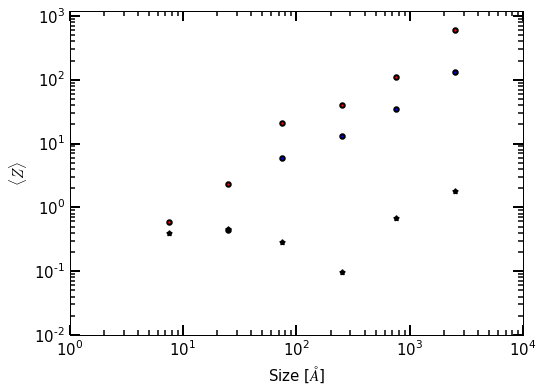

In [83]:
fig = plt.figure(figsize=(7,5))

ax = fig.add_axes([0.5, 0.5, 0.9, 0.9])
ax.scatter(Test_sizes, Zcent_CNM, c="b", marker="o", linewidths=2)
ax.scatter(Test_sizes, Zcent_WNM, c="r", marker="o", linewidths=2)
ax.scatter(Test_sizes, abs(Zcent_CMM), c="k", marker="*", linewidths=2)


ax.set_xscale("log")
ax.set_yscale("log")

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

#ax.set_xlabel("$a_{400}$ $(G\\sqrt{T} / n_{e})^{0.58}$ - $a_{57}$", fontsize=15)
ax.set_xlabel("Size [$\\AA$]", fontsize=15)
ax.set_ylabel("$\\langle Z \\rangle$", fontsize=15)

#ax.set_yscale(np.min(abs(Zcent_CMM)), np.max(Zcent_WNM))
ax.set_ylim(1.0e-2, 1200)

fig.show()

In [84]:
# PDR
G = 1.0e3
T = 1000.
ne = 1.0
GTn = G*np.sqrt(T) / ne

Zcent_PDR = function(GTn, alpha, a, b, h)

In [85]:
print(size)
print(alpha)

[    3.5     5.     10.     50.    100.    500.   1000. ]
[ 0.3263  0.3141  0.3535  0.5115  0.3525  0.3643  0.3927]


In [86]:
print(size)
print(Zcent_PDR)

[    3.5     5.     10.     50.    100.    500.   1000. ]
[   0.31686269    0.65951336    1.43870486   13.95319359   25.25660814
  115.07957131  214.32006646]


---

In [47]:
# Calculate charge distribution: Same sizes and environments.

import fzMPI
import yt
from yt.units import pc, kpc, second, Kelvin, gram, erg, cm
import compute_charge_dist as fz

In [48]:
# Define some constant parameters to be used.
mp      = 1.6726e-24  * gram # g
mH      = 1.6733e-24  * gram
mC      = 12.011*mH
#mu      = 1.2924
kb      = 1.3806e-16  *erg / Kelvin # erg K-1
GNewton = 6.6743e-8   * cm**3 / (gram * second**2 )# cm3 g-1 s-2
Msun    = 1.9884e33   * gram
#mm      = mu*mp

ppc = 3.0856776e18

# -------------------------------------------------------------
#              Create a lot of new derived fields
# -------------------------------------------------------------

# Create a derived field.
# Hydrogen number density
def numdensH(field, data): 
    nH = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    return nH

# Molecular Hydrogen number density
def numdensH2(field, data): 
    nH2 = data["dens"]*(data["ih2 "])/(1.4*mH)
    return nH2

# Carbon number density
def numdensC(field, data): 
    nC = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    return nC

# electron number density
def numdense(field, data): 
    ne = data["dens"]*(data["ihp "]/(1.4*mH) + data["icp "]/(1.4*mC))
    return ne

# Ionized hydrogen fraction
def xHp(field, data): 
    nH  = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    xHp = data["dens"]*data["ihp "]/(1.4*mH)
    xHp = xHp / nH
    return xHp

# Molecular hydrogen fraction
def xH2(field, data): 
    nH  = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    xH2 = data["dens"]*data["ih2 "]/(1.4*mH)
    xH2 = xH2 / nH
    return xH2

# Ionized carbon fraction
def xCp(field, data): 
    nC  = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    xCp = data["dens"]*data["icp "]/(1.4*mC) / nC
    return xCp

# electron fraction
def xe(field, data): 
    nH = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    nC = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    ne = data["dens"]*(data["ihp "]/(1.4*mH) + data["icp "]/(1.4*mC))
    xe = ne / (nH + nC)
    return xe

# electron fraction
#def GG(field, data): 
#    G = fz.get_G(data["cdto"], 1.68)
#    return G


yt.add_field('nH', function=numdensH,  units="1/cm**3", force_override=True)
yt.add_field('nH2',function=numdensH2, units="1/cm**3", force_override=True)
yt.add_field('nC', function=numdensC,  units="1/cm**3", force_override=True)
yt.add_field('ne', function=numdense,  units="1/cm**3", force_override=True)
yt.add_field('xHp', function=xHp,      units="dimensionless", force_override=True)
yt.add_field('xH2', function=xH2,      units="dimensionless", force_override=True)
yt.add_field('xCp', function=xCp,      units="dimensionless", force_override=True)
yt.add_field('xe', function=xe,        units="dimensionless", force_override=True)
#yt.add_field('G',  function=GG,        units="dimensionless", force_override=True)

fzMPI.print_to_logfile("Initializing clock.")

# Input variables.
data_dir   = "/home/jcibanezm/codes/run/Silcc/CF_Prabesh"
#data_dir   = "/Users/juan/codes/run/Silcc/CF_Prabesh"
filename   = data_dir + "/NL99_R8_cf_hdf5_chk_0028"

pf = yt.load("%s"%(filename))

c  = [0,0,0]
le = [-4.93696000e+19, -4.93696000e+19, -4.93696000e+19]
re = [ 4.93696000e+19,  4.93696000e+19,  4.93696000e+19]

box = pf.box(le, re)

min_dens = np.min(box["density"])
max_dens = np.max(box["density"])

min_nh   = np.min(box["nH"])
max_nh   = np.max(box["nH"])

min_temp = np.min(box["temperature"])
max_temp = np.max(box["temperature"])

min_ne = np.min(box["ne"])
max_ne = np.max(box["ne"])

min_xe = np.min(box["xe"])
max_xe = np.max(box["xe"])

min_Av = np.min(box["cdto"])
max_Av = np.max(box["cdto"])

yt : [INFO     ] 2018-11-08 16:33:33,177 Particle file found: NL99_R8_cf_hdf5_chk_0028
yt : [INFO     ] 2018-11-08 16:33:33,183 integer runtime parameter checkpointfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-11-08 16:33:33,183 integer runtime parameter forcedplotfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-11-08 16:33:33,184 integer runtime parameter nbegin overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-11-08 16:33:33,184 integer runtime parameter plotfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-11-08 16:33:33,199 Parameters: current_time              = 5.68049127342e+14
yt : [INFO     ] 2018-11-08 16:33:33,200 Parameters: domain_dimensions         = [32  8  8]
yt : [INFO     ] 2018-11-08 16:33:33,201 Parameters: domain_left_edge          = [ -1.97478400e+20  -4.93696000e+19  -4.93696000e+19]
yt : [INFO     ] 2018-11-08 16:33:33,202 Parameters: domain_righ

Initializing clock.


In [49]:
wnm = ((box["temperature"].in_units("K") > 6.0e3)&(box["temperature"].in_units("K") < 1.0e4)&(box["iha "] > 0.6)&(box["nH"] >= 0.75))
cnm = ((box["temperature"].in_units("K") > 50)   &(box["temperature"].in_units("K") < 70)   &(box["iha "] > 0.6))
cmm = ((box["temperature"].in_units("K") < 50)   &(box["ih2 "] > 0.6) &(box["nH"] <1.0e5))

wnmtrue = np.argwhere(wnm==True)
cnmtrue = np.argwhere(cnm==True)
cmmtrue = np.argwhere(cmm==True)

wnmindex = wnmtrue[0]
#wnmindex = [3626974]
cnmindex = cnmtrue[0]
#cmmindex = cmmtrue[3626974]
cmmindex = [3479445]

#grain_type = "carbonaceous"
grain_type = "silicate"
grain_size = [7.5, 25, 75, 250, 750, 2500]
#grain_size = [25, 75, 25, 75, 20]

G0         = 1.7

Qabs7    = fz.get_QabsTable(grain_type, 7.5 )
Qabs25    = fz.get_QabsTable(grain_type, 25 )
Qabs75    = fz.get_QabsTable(grain_type, 75)
Qabs250   = fz.get_QabsTable(grain_type, 250)
Qabs750   = fz.get_QabsTable(grain_type, 750 )
Qabs2500  = fz.get_QabsTable(grain_type, 2500)

Qabs = [Qabs7, Qabs25,Qabs75,Qabs250,Qabs750,Qabs2500]

I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain


In [54]:
indexarr = np.array([wnmindex, cnmindex, cmmindex])

temp= np.array( box["temp"][indexarr])
dd  = np.array( box["dens"][indexarr])
nH  = np.array( box["nH"]  [indexarr])
nH2 = np.array( box["nH2"]  [indexarr])
nC  = np.array( box["nC"]  [indexarr])
ne  = np.array( box["ne"]  [indexarr])
xe  = np.array( box["xe"]  [indexarr])
xHp = np.array( box["xHp"]  [indexarr])
xH2 = np.array( box["xH2"]  [indexarr])
xCp = np.array( box["xCp"]  [indexarr])
Av  = np.array( box["cdto"][indexarr])
fH2shield  = np.array( box["cdh2"][indexarr])

Ntot =  Av * 1.87e21

In [52]:
NH2 = np.zeros(3)
for i in range(3):
    NH2[i] = fz.get_NH2(fH2shield[i], temp[i])

In [57]:
#zmean, zmode, zstd  =  np.zeros(15), np.zeros(15), np.zeros(15)
zmean, zmode, zstd  =  np.zeros((3,6)), np.zeros((3,6)), np.zeros((3,6))
zminmax = np.array(np.zeros(2*18))
fdist   = []
fdistCR   = []
phase = ["WNM", "CNM", "CMM"]

# loop over grain sizes
for kk in range(6):
    # loop over ISM phases.
    for ii in range(3):
        
        print("Running grain size %i, phase %s"%(grain_size[kk], phase[ii]))
        
        zeta = fz.get_zeta(NH2[ii])

        ############################################################################################
        # Run the charge distribution calculation!!!
        Jpe, Je, Jh, Jc, ZZall = fz.compute_currents ([nH[ii], nC[ii]], [xHp[ii], xCp[ii]], xH2[ii], temp[ii], zeta, grain_size[kk], Ntot[ii], grain_type, Qabs[kk], G0=G0)
        JCRe, JCRpe, ZZnew     = fz.compute_CR_currents(nH[ii], zeta, grain_size[kk], grain_type, Qabs[kk])

        zeq                    = fz.get_zeq_vec      (Jpe, Je, Jh, Jc, ZZall, grain_size[kk], grain_type)
        new_zmin, new_zmax     = fz.get_new_zmin_zmax([nH[ii], nC[ii]], [xHp[ii], xCp[ii]], temp[ii], grain_size[kk], Ntot[ii], grain_type, Qabs[kk], zeta, zeq=zeq, G0=G0, includeCR=True)    
        #new_zmin, new_zmax     = int(fz.get_Zmin(grain_size[ii], grain_type[ii])), int(fz.get_Zmax(grain_size[ii], grain_type[ii]))       
        
        #fz, ZZ                = fz.vector_fz        (Jpe, Je, Jh, Jc, JCRe, JCRpe, ZZall, new_zmin, new_zmax, includeCR=False)
        ffz, ZZ              = fz.vector_fz        (Jpe, Je, Jh, Jc, JCRe, JCRpe, ZZall, new_zmin, new_zmax, includeCR=True)
        #ffz, ZZ                = fz.vector_fz        (Jpe, Je, Jh, Jc, ZZall, new_zmin, new_zmax)

        avg, std  = fz.weighted_avg_and_std(ZZ, ffz)
    
        print("Charge centroid = ", avg)
        print("Charge width    = ", std)

        #zmean[ii+kk*3] = avg
        #zstd[ii+kk*3]  = std
        zmean[ii, kk] =  avg
        zstd[ii, kk]  =  std

        #print("Zmin index = %i"%(ii*2+  2*kk*3))
        #print("zmin = %i"%(new_zmin))
        #print("Zmax index = %i"%(ii*2+1+2*kk*3))
        #print("zmax = %i"%(new_zmax))


        zminmax[ii*2+  2*kk*3]  = new_zmin
        zminmax[ii*2+1+2*kk*3]  = new_zmax
        
        #print(zminmax)

        #fdist[ii]   = offset + ii
        for jj in range(len(ffz)):
            fdist.append(ffz[jj])

            
        #print(ffz)
        #print(ZZ)

Running grain size 7, phase WNM
('Charge centroid = ', 0.60018887181599601)
('Charge width    = ', 0.66644946599267)
Running grain size 7, phase CNM
('Charge centroid = ', 0.02058097385170659)
('Charge width    = ', 0.40626666470760137)
Running grain size 7, phase CMM
('Charge centroid = ', -0.19252508628067949)
('Charge width    = ', 0.43315354051015464)
Running grain size 25, phase WNM
('Charge centroid = ', 3.172147109875576)
('Charge width    = ', 1.2199230161824517)
Running grain size 25, phase CNM
('Charge centroid = ', 0.55909205837676046)
('Charge width    = ', 0.773358740324529)
Running grain size 25, phase CMM
('Charge centroid = ', -0.097105092565408571)
('Charge width    = ', 0.5016503069911178)
Running grain size 75, phase WNM
('Charge centroid = ', 13.041066171376723)
('Charge width    = ', 1.9892589645871612)
Running grain size 75, phase CNM
('Charge centroid = ', 3.6897044188573433)
('Charge width    = ', 1.7278322615626327)
Running grain size 75, phase CMM
('Charge cen

In [58]:
print("25 AA, warm, cold, molecular, 75 AA WNM, CNM, CMM")
print(zmean[0,:])

25 AA, warm, cold, molecular, 75 AA WNM, CNM, CMM
[   0.60018887    3.17214711   13.04106617   44.42967253  113.88553048
  331.10690607]


In [87]:
Zdiff_CMM = zmean[2,:] - Zcent_CMM
Zdiff_CNM = zmean[1,:] - Zcent_CNM
Zdiff_WNM = zmean[0,:] - Zcent_WNM

In [88]:
print(Zdiff_CMM)

[ 0.2022565   0.36016109  0.72909618  1.67790052  2.43053853  5.7463524 ]


In [90]:
print(Zdiff_CNM)

[  1.70916145e-02   1.17464945e-01  -2.21634467e+00   2.88256611e+00
   1.06106122e+00  -4.15591918e+01]


In [89]:
print(Zdiff_WNM)

[  6.17658489e-03   8.63635554e-01  -7.63291212e+00   4.67296941e+00
   4.15530965e+00  -2.62773113e+02]


In [62]:
print(zmean[0,:])

[   0.60018887    3.17214711   13.04106617   44.42967253  113.88553048
  331.10690607]


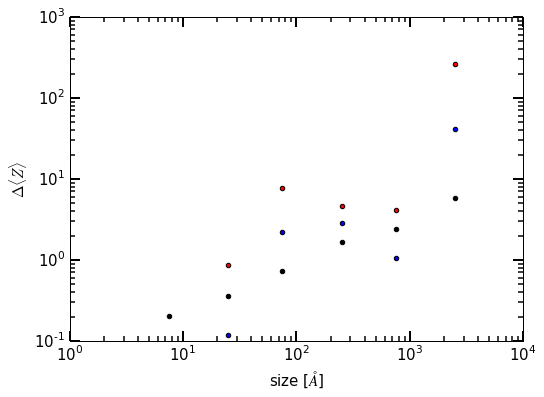

In [91]:
fig = plt.figure(figsize=(7,5))

ax = fig.add_axes([0.5, 0.5, 0.9, 0.9])

ax.scatter(Test_sizes, np.abs(Zdiff_CMM), c='k')
ax.scatter(Test_sizes, np.abs(Zdiff_CNM), c='b')
ax.scatter(Test_sizes, np.abs(Zdiff_WNM), c='r')


#ax.scatter(Test_sizes, Zcent_CNM, c="b", marker="o", linewidths=2)
#ax.scatter(Test_sizes, Zcent_WNM, c="r", marker="o", linewidths=2)
#ax.scatter(Test_sizes, abs(Zcent_CMM), c="k", marker="*", linewidths=2)

ax.set_xscale("log")
ax.set_yscale("log")

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

#ax.set_xlabel("$a_{400}$ $(G\\sqrt{T} / n_{e})^{0.58}$ - $a_{57}$", fontsize=15)
ax.set_xlabel("size [$\\AA$]", fontsize=15)
ax.set_ylabel("$\\Delta \\langle Z \\rangle$", fontsize=15)

#ax.set_yscale(np.min(abs(Zcent_CMM)), np.max(Zcent_WNM))
#ax.set_ylim(0.4, 800)

fig.show()

In [131]:
print(Zcent_CNM)

[  3.48935940e-03   4.41627114e-01   5.90604909e+00   1.32652015e+01
   3.51258071e+01   1.33905178e+02]


In [133]:
print(zmean[1,:])

[  2.05809739e-02   5.59092058e-01   3.68970442e+00   1.61477676e+01
   3.61868683e+01   9.23459864e+01]


In [93]:
print(Test_sizes)

[7.5, 25, 75, 250, 750, 2500]


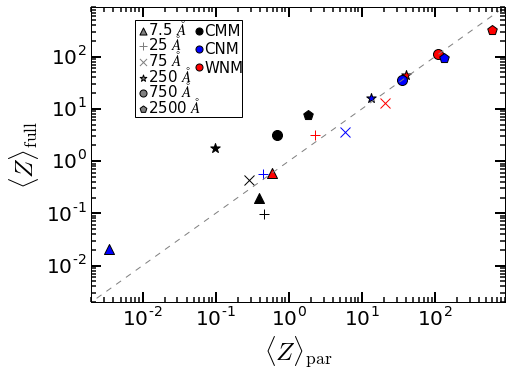

In [173]:
import matplotlib.patches as patches

fig = plt.figure(figsize=(7,5))

ax = fig.add_axes([0.17, 0.17, 0.82, 0.82])

ax.plot(np.arange(-1, 750), np.arange(-1, 750), "grey", linestyle='dashed')

markers = ["^", "+", "x", "*", "o", "p"]

for i in range(len(markers)):
    ax.scatter(np.abs(Zcent_CMM[i]), np.abs(zmean[2,i]), c='k', marker=markers[i], s=100)
    ax.scatter(np.abs(Zcent_CNM[i]), np.abs(zmean[1,i]), c='b', marker=markers[i], s=100)
    ax.scatter(np.abs(Zcent_WNM[i]), np.abs(zmean[0,i]), c='r', marker=markers[i], s=100)


#ax.scatter(Test_sizes, Zcent_CNM, c="b", marker="o", linewidths=2)
#ax.scatter(Test_sizes, Zcent_WNM, c="r", marker="o", linewidths=2)
#ax.scatter(Test_sizes, abs(Zcent_CMM), c="k", marker="*", linewidths=2)

ax.set_xscale("log")
ax.set_yscale("log")

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=20, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=20, direction="in")

#ax.set_xlabel("$a_{400}$ $(G\\sqrt{T} / n_{e})^{0.58}$ - $a_{57}$", fontsize=15)
ax.set_xlabel("$\\langle Z \\rangle_{\mathrm{par}}$", fontsize=25)
ax.set_ylabel("$\\langle Z \\rangle_{\mathrm{full}}$", fontsize=25)

marky = np.logspace(2.5, 1.0, 6, endpoint=True)
phasey = np.logspace(2.5,1.8, 3, endpoint=True)

for i in range(len(markers)):
    ax.scatter(0.01, marky[i], c='grey', marker=markers[i], s=50)
    if i ==0 :
        ax.text   (0.012, marky[i]*0.85, "%.1f $\\AA$"%(Test_sizes[i]), fontsize=15)
    else:
        ax.text   (0.012, marky[i]*0.85, "%.0f $\\AA$"%(Test_sizes[i]), fontsize=15)
        
colors = ["black", "blue", "red"]
phases = ["CMM", "CNM", "WNM"]

for i in range(len(phasey)):
    ax.scatter(0.06, phasey[i], s=50, c=colors[i])
    ax.text(0.070, phasey[i]*0.8, phases[i], fontsize=15)

rect = patches.Rectangle((0.008, 7), 0.22, 500, linewidth=1, edgecolor='k', facecolor='none')

ax.add_patch(rect)

#ax.set_yscale(np.min(abs(Zcent_CMM)), np.max(Zcent_WNM))
ax.set_ylim(0.002, 900)
ax.set_xlim(0.002, 900)

fig.show()

fig.savefig("/home/jcibanezm/Dropbox/Projects/Papers/In_Progress/ChargeDist_Dust/Figures/Figure8_Test.pdf", format="pdf")